In [1]:
from scipy.io import loadmat,savemat
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
#from scipy.spatial.distance import squareform
#from cupyx.scipy.spatial.distance import pdist
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import dff
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform

def remove_zero_rows_cols(matrix):
   
    matrix = matrix[~np.all(matrix == 0, axis=1)]
    
    matrix = matrix[:, ~np.all(matrix == 0, axis=0)]
    return matrix

from matplotlib.font_manager import FontProperties
font = FontProperties()

font.set_size(5)  

def compute_dff_Allen(traces, fs):
   
    index_long = int(300*fs//2*2+1)
    index_short = int((10/3)*fs//2*2+1)

    traces_dff = dff.compute_dff_windowed_median(traces,
                                                 median_kernel_long=index_long,
                                                 median_kernel_short=index_short)
    
    return traces_dff


def compute_dff_Allen_parallel(traces, fs, n_jobs, batch_size):
   
    ROI_num = traces.shape[0]

    traces_dff = Parallel(n_jobs=n_jobs)(delayed(compute_dff_Allen)(traces[i:min(i+batch_size, ROI_num), :], fs) for i in range(0, ROI_num, batch_size))

    traces_dff = np.concatenate(traces_dff, axis=0)

    return traces_dff

def pca_reconstruction(data, variance_threshold=0.95, standardize=False):
   
    
    
    if standardize:
        scaler = StandardScaler()
        data_processed = scaler.fit_transform(data)
    else:
        scaler = None
        data_processed = data.copy()

   
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    pca.fit(data_processed)
    
    print(f"Preserve variance proportion: {variance_threshold*100}%")
    print(f"Select the number of principal components: {pca.n_components_}")
    print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

   
    reconstructed_processed = pca.inverse_transform(pca.transform(data_processed))
    
   
    if standardize:
        reconstructed = scaler.inverse_transform(reconstructed_processed)
    else:
        reconstructed = reconstructed_processed

    return reconstructed, pca, scaler

In [ ]:
exp='yourlocation/pca_pretreat_full/testData'
datapath = '/'+exp;
data = loadmat(os.path.join(datapath, "Ori3dCellTrace.mat"))

nucArea = data['nucArea'] 
trace = data['trace'] 
nucIndex = data['nucIndex']

smallArea = np.squeeze(nucArea <= 4) 
trace = np.delete(trace, np.where(smallArea), axis=0) 

nucIndex = np.delete(nucIndex, np.where(smallArea))

del(data)

traces_dff = compute_dff_Allen_parallel(trace, fs=1, n_jobs=30, batch_size=6)

reconstructed, _ , _ = pca_reconstruction(traces_dff)#

print('running corr1...')
corr1 = squareform(pdist(reconstructed, "correlation"))

corr1=1-corr1;
indices = np.diag_indices(corr1.shape[0])
corr1[indices] = 0

Preserve variance proportion: 95.0%
Select the number of principal components: 28
Cumulative explained variance: 95.14%
running corr1...


In [3]:
nucNo = np.unique(nucIndex) 
neural = np.zeros((len(nucNo), trace.shape[1]))
for i in range(len(nucNo)): 
    sameNuc = nucIndex == nucNo[i] 
    if np.sum(sameNuc) > 1: 
     
        neural[i, :] = np.mean(traces_dff[sameNuc, :], axis=0)
    else: 
     
        neural[i, :] = traces_dff[sameNuc, :]

reconstructed, _ , _ = pca_reconstruction(neural)
print('running corr2...')
corr2 = squareform(pdist(reconstructed, "correlation"))

corr2=1-corr2;
indices = np.diag_indices(corr2.shape[0])
corr2[indices] = 0

Preserve variance proportion: 95.0%
Select the number of principal components: 24
Cumulative explained variance: 95.23%
running corr2...


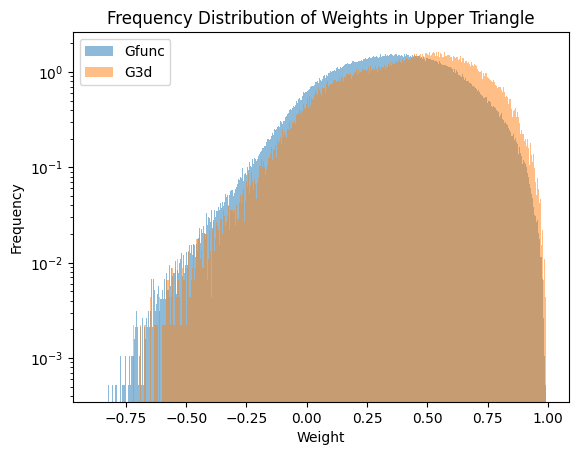

In [4]:
upper_triangle = np.triu(corr1, k=1)

weights = upper_triangle[upper_triangle != 0]

if np.isnan(weights).any():
    weights = weights[~np.isnan(weights)]

plt.hist(weights, bins=10000,
         log=True,
         density=True,
         label='Gfunc',alpha=0.5)

upper_triangle = np.triu(corr2, k=1)
weights = upper_triangle[upper_triangle != 0]

if np.isnan(weights).any():
    weights = weights[~np.isnan(weights)]


plt.hist(weights, bins=10000,
         log=True,
         density=True,
         label='G3d',alpha=0.5)


plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Weights in Upper Triangle')
plt.legend()
plt.show()

del(upper_triangle,weights)

In [5]:
from scipy.sparse.linalg import eigsh

ecGfun={}
ecG3d={}

eigenvalues, eigenvectors = eigsh(np.abs(corr1.astype('float32')), k=1, which='LM',)

eigenvector_centrality = np.abs(eigenvectors[:, 0])
eigenvector_centrality /= np.linalg.norm(eigenvector_centrality, ord=1) 

ecGfun[exp]=eigenvector_centrality * (corr1.shape[0] / corr2.shape[0])

In [6]:
eigenvalues, eigenvectors = eigsh(np.abs(corr2.astype('float32')), k=1, which='LM',)
eigenvector_centrality = np.abs(eigenvectors[:, 0])
eigenvector_centrality /= np.linalg.norm(eigenvector_centrality, ord=1)
ecG3d[exp]=eigenvector_centrality

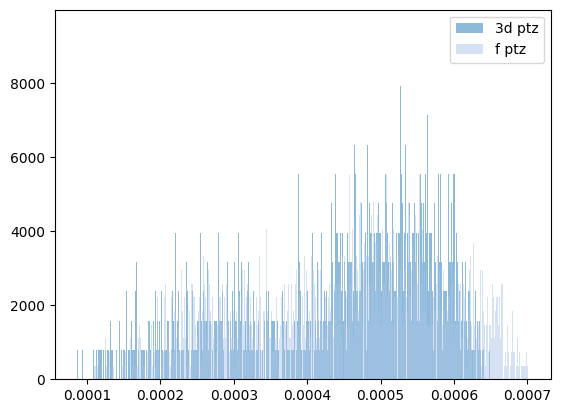

In [7]:
colors = [
    (31, 119, 180),  
    (174, 199, 232),
    (255, 127, 14),  
    (255, 187, 120), 
]

colors = [(r/255, g/255, b/255) for r, g, b in colors]

alphas = [0.5, 0.5, 0.5, 0.5] 
labels=['3d ptz', 'f ptz', '3d spon', 'f spon']


for i, array in enumerate([ecG3d[exp], ecGfun[exp]]):
    plt.hist(array, bins=1000, color=colors[i], alpha=alphas[i], 
             density=True,
             label=labels[i]
            )

plt.legend()
plt.show()

In [9]:
import networkx as nx

def create_network(adj_matrix, indexs, threshold=0.95):
    G = nx.Graph()
    n = adj_matrix.shape[0]
    

    for i in range(n):
        G.add_node(i, ind=indexs[i])
    

    for i in range(n):
        for j in range(i+1, n):
            if abs(adj_matrix[i, j]) > threshold:
                G.add_edge(i, j)
    

    largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc)


def calculate_metrics(graph):
    print('\nDegree:')
    degree = dict(graph.degree())
    clustering = nx.clustering(graph)
    metrics = {
        'degree': degree,
        'clustering': clustering
    }
    return metrics


def plot_metric_hist(metric_name, metrics1, metrics2, G1, G2):
    
    fig, ax = plt.subplots(figsize=(15,15))
    cmName1='muted'
    cmName2='pastel'

    nodes = list(G1.nodes())
    metrics1=[metrics1[metric_name][n] for n in nodes]

    nodes = list(G2.nodes())
    metrics2=[metrics2[metric_name][n] for n in nodes]
    
    labels=[f'{exp} treated \nwithout 3d identified', f'{exp} treated \nwith 3d identified']

    bins=np.logspace(0,14,15,base=2)-0.5

    

    hist, bins = np.histogram(metrics1, 
                              bins=bins, 
                              density=True);
    x=(bins[:-1]+bins[1:])/2
    
    plt.plot(x[hist>0],hist[hist>0],'o-',
             markersize='12',
             color=sns.color_palette(cmName2)[0],
             label=labels[0]
            )

    hist, bins = np.histogram(metrics2, bins=bins, density=True);
    plt.plot(x[hist>0],hist[hist>0],'o-',
                 markersize='12',
                 color=sns.color_palette(cmName1)[0],
                 label=labels[1]
                )
    
    ax.lines[0].set(linewidth=4, linestyle='--', alpha=0.9)
    ax.lines[1].set(linewidth=4, linestyle='-', alpha=0.9)

    plt.title('Comparison of Degree Distributions',fontproperties=font);
 
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Degree',fontproperties=font);
    ax.set_ylabel('Probability',fontproperties=font);

    
    plt.legend(fontsize=32,
               handletextpad=0.5,
               numpoints=2,
               frameon=False)
    
    plt.tick_params(axis='x', which='major',direction='in',length=18 ,labelsize=32,pad=9)
    plt.tick_params(axis='x', which='minor',direction='in',length=9)
    plt.tick_params(axis='y', which='major',direction='in',length=18 ,labelsize=32)
    plt.tick_params(axis='y', which='minor',direction='in',length=9)
    
    ax.spines['left'].set_linewidth(3)   
    ax.spines['bottom'].set_linewidth(3) 
    ax.spines['right'].set_linewidth(3)  
    ax.spines['top'].set_linewidth(3)    
    
    plt.tight_layout()

In [10]:
th = 0.95
G1 = create_network(corr1, nucIndex, th)
G2 = create_network(corr2, nucNo, th)
metrics1 = calculate_metrics(G1)
metrics2 = calculate_metrics(G2)


Degree:

Degree:


/tmp/ipykernel_1540584/2774387068.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


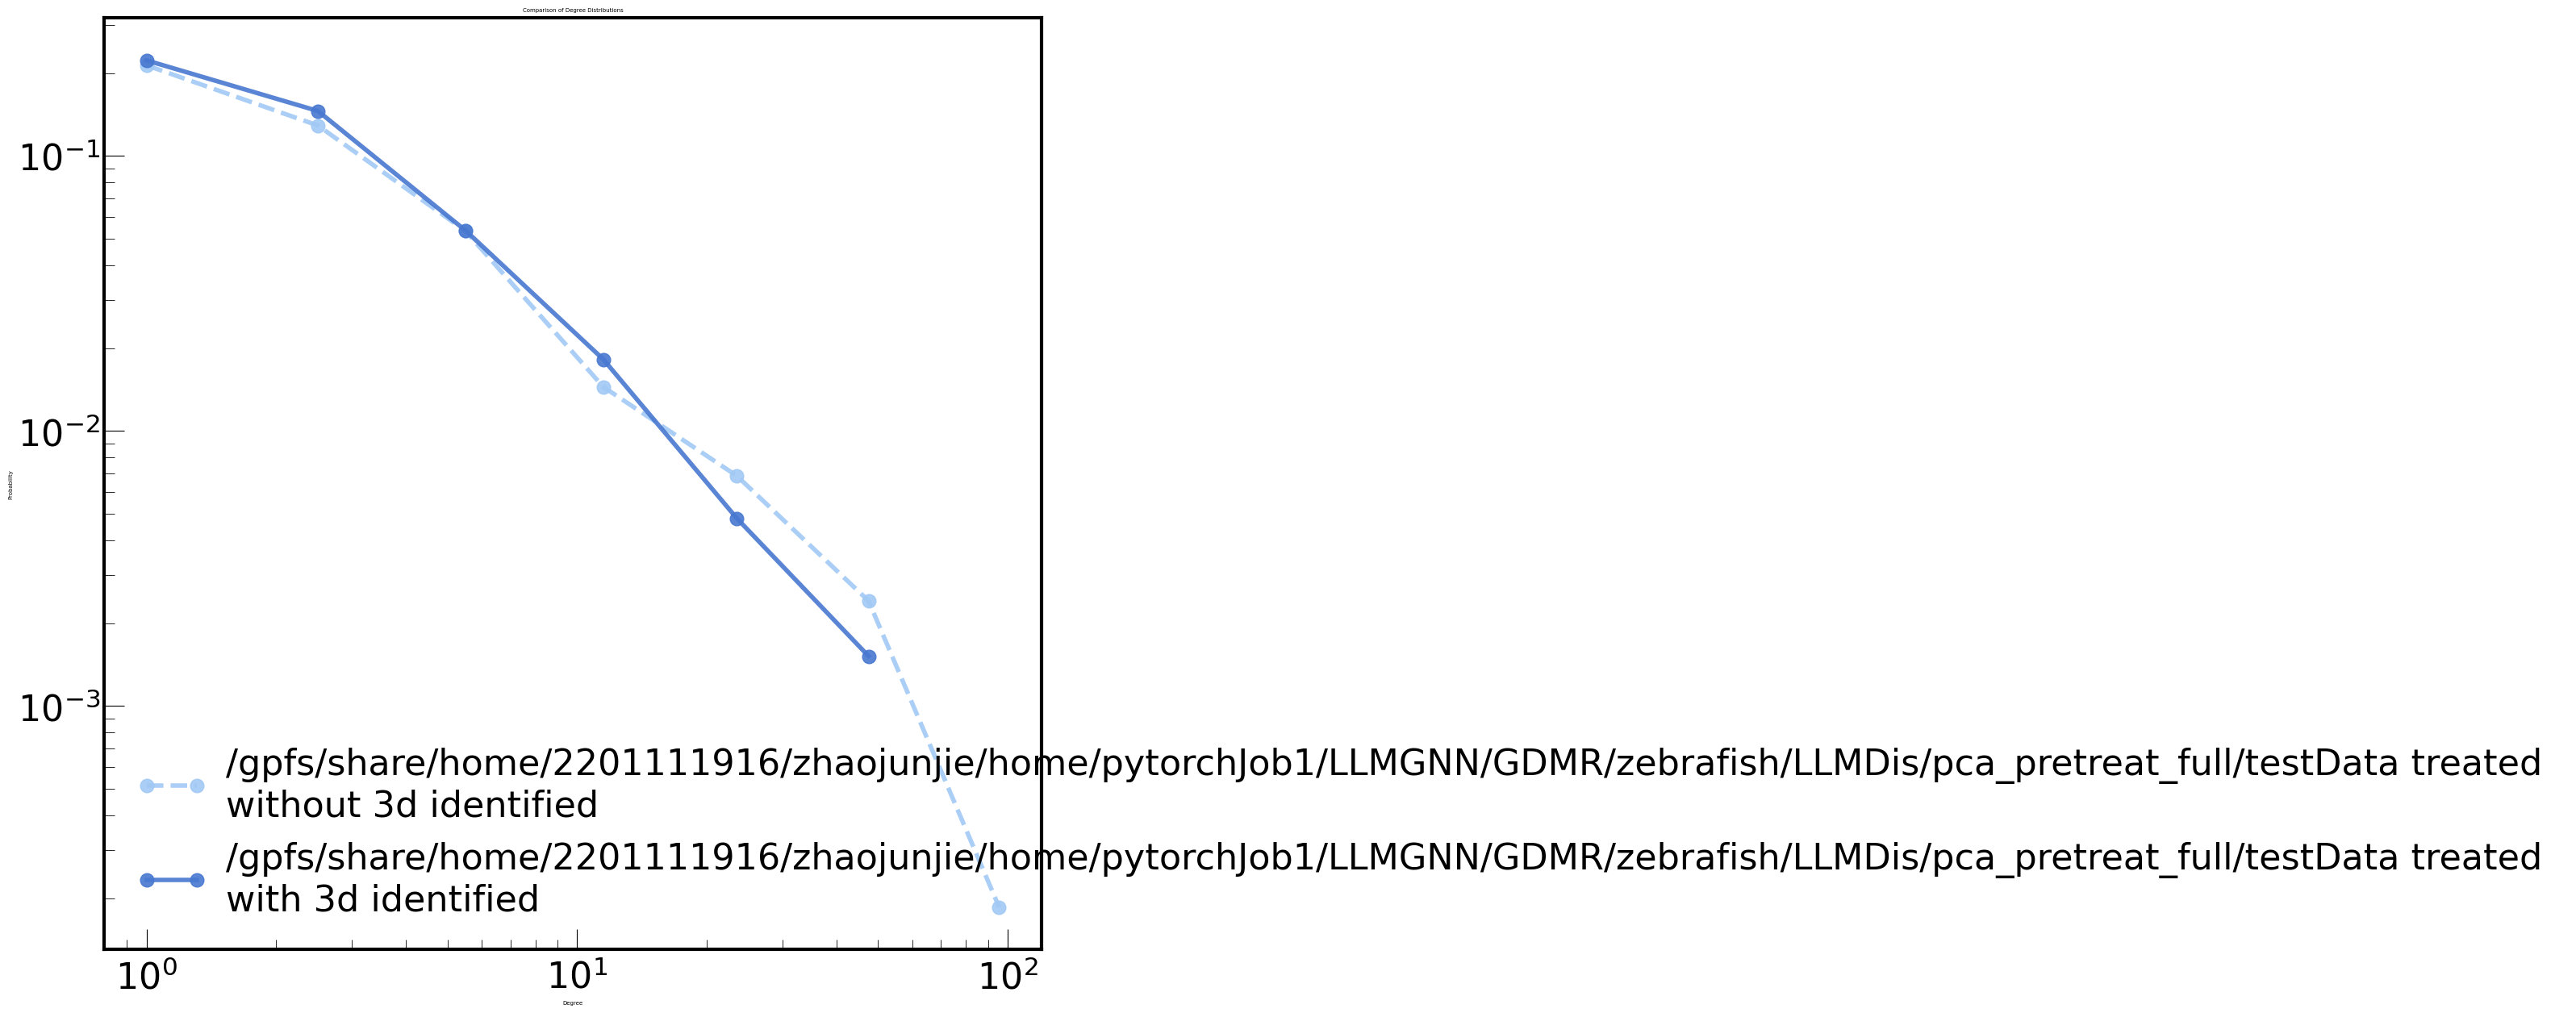

In [11]:
plot_metric_hist('degree', metrics1,metrics2,G1,G2)